# 04 — Report: Pairs Trading (Load → Summarize → Visualize)

**Goal.** Produce a clean report from previously saved artifacts. We load outputs from `03_backtest` and render portfolio/per-pair results that are easy to compare and export.

**Inputs (from `data/interim/`):**
- `stats_pairs_is.parquet`, `stats_pairs_oos.parquet` — per-pair metrics on IS and OOS.
- `pnl_is.parquet`, `pnl_oos.parquet` *(if present)* — portfolio PnL time series.
- Fallback: `pnl_pairs_is.parquet`, `pnl_pairs_oos.parquet` — used to reconstruct portfolio PnL by equal-weight averaging across pairs.
- `portfolio_report.parquet` *(if present)* — cached summary table (IS/OOS).


### What this block does

- **Finds the correct `data/interim/` folder** even if the notebook runs from `notebooks/` by probing `data/interim`, `../data/interim`, `../../data/interim`.
- **Loads required artifacts** produced by `03_backtest`:
  - Per-pair stats: `stats_pairs_is.parquet`, `stats_pairs_oos.parquet`.
  - Portfolio PnL: uses `pnl_is.parquet`, `pnl_oos.parquet` if present; otherwise **rebuilds** them by averaging `pnl_pairs_is.parquet` and `pnl_pairs_oos.parquet` across pairs.
  - Portfolio summary: reads `portfolio_report.parquet` if available; else recomputes metrics with `perf_stats`.
- **Produces plots**:
  - Portfolio **equity curves** (IS vs OOS) from cumulative PnL.
  - Portfolio **drawdown** curves (IS vs OOS).
  - **Scatter** of per-pair **IS vs OOS Sharpe** to visualize stability and degradation.
- **Displays summary tables**: overall portfolio metrics (IS/OOS) and top pairs by OOS Sharpe.


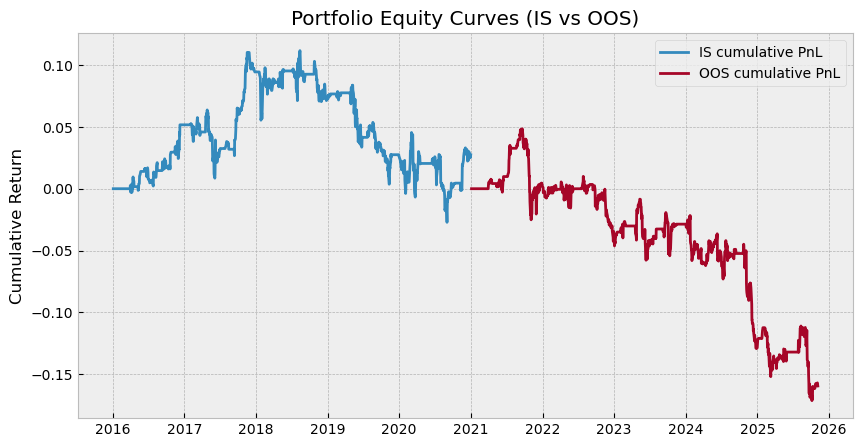

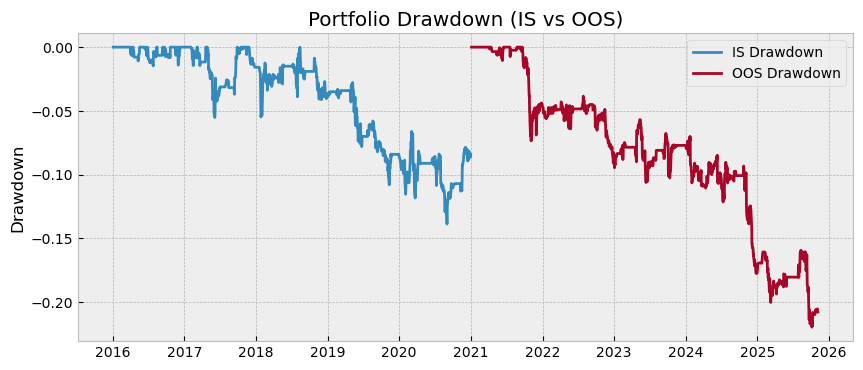

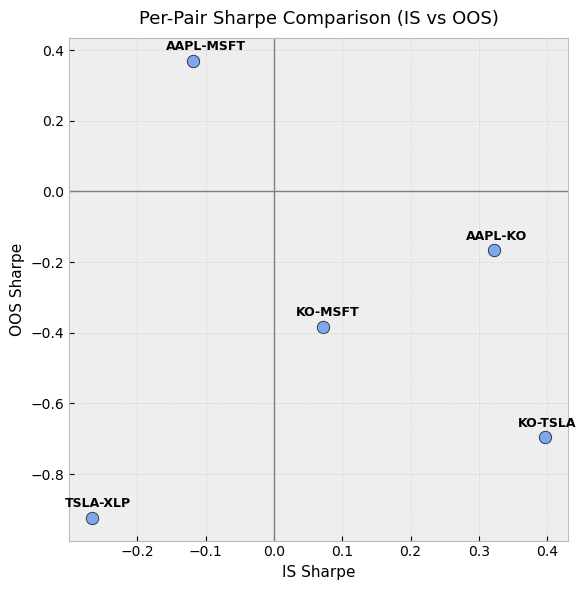

=== Portfolio Summary ===


,period,ann_return,ann_vol,sharpe,max_drawdown
0,IS,0.005491,0.053620,0.102412,-0.132413
1,OOS,-0.033026,0.053018,-0.622923,-0.202373


=== Per-Pair Sharpe (IS vs OOS) — top by OOS ===


,IS_Sharpe,OOS_Sharpe
pair,,
AAPL-MSFT,-0.118809,0.369898
AAPL-KO,0.321714,-0.166826
KO-MSFT,0.071492,-0.383807
KO-TSLA,0.397430,-0.696316
TSLA-XLP,-0.266717,-0.923687


In [38]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

from helpers import perf_stats  # from previous notebooks

# --- Locate data/interim robustly (supports running from /, /notebooks, etc.) ---
def locate_interim() -> Path:
    candidates = [
        Path("data") / "interim",
        Path("..") / "data" / "interim",
        Path("..") / ".." / "data" / "interim",
    ]
    for p in candidates:
        if (p / "stats_pairs_is.parquet").exists() or (p / "pnl_pairs_is.parquet").exists():
            return p
    # Fallback to first candidate; downstream loader will raise clear error
    return candidates[0]

INTERIM = locate_interim()

def load_parquet_strict(path: Path) -> pd.DataFrame:
    """Load parquet with a clear error if missing."""
    if not path.exists():
        raise FileNotFoundError(
            f"Expected file not found: {path}\n"
            f"Working dir: {Path.cwd()}\n"
            "Make sure 03_backtest saved outputs into data/interim and the path is correct."
        )
    return pd.read_parquet(path)

# --- Required per-pair stats ---
stats_is  = load_parquet_strict(INTERIM / "stats_pairs_is.parquet")
stats_oos = load_parquet_strict(INTERIM / "stats_pairs_oos.parquet")

# --- Portfolio-level PnL: use aggregated files if present, otherwise average per-pair ---
pnl_is_path  = INTERIM / "pnl_is.parquet"
pnl_oos_path = INTERIM / "pnl_oos.parquet"

if pnl_is_path.exists() and pnl_oos_path.exists():
    pnl_is  = pd.read_parquet(pnl_is_path)
    pnl_oos = pd.read_parquet(pnl_oos_path)
else:
    pnl_pairs_is  = load_parquet_strict(INTERIM / "pnl_pairs_is.parquet")
    pnl_pairs_oos = load_parquet_strict(INTERIM / "pnl_pairs_oos.parquet")
    pnl_is  = pnl_pairs_is.mean(axis=1).to_frame("pnl")
    pnl_oos = pnl_pairs_oos.mean(axis=1).to_frame("pnl")

# --- Portfolio report (use saved if exists; else recompute) ---
port_report_path = INTERIM / "portfolio_report.parquet"
if port_report_path.exists():
    portfolio_report = pd.read_parquet(port_report_path)
else:
    row_is  = {"period": "IS",  **perf_stats(pnl_is["pnl"])}
    row_oos = {"period": "OOS", **perf_stats(pnl_oos["pnl"])}
    portfolio_report = pd.DataFrame([row_is, row_oos])

# --- Equity curves (cumulative PnL) ---
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pnl_is.index,  pnl_is["pnl"].cumsum(),  label="IS cumulative PnL")
ax.plot(pnl_oos.index, pnl_oos["pnl"].cumsum(), label="OOS cumulative PnL")
ax.set_title("Portfolio Equity Curves (IS vs OOS)")
ax.set_ylabel("Cumulative Return")
ax.legend()
plt.show()

# --- Drawdown curves ---
def drawdown(pnl_df: pd.DataFrame) -> pd.Series:
    equity = pnl_df["pnl"].cumsum()
    peak = equity.cummax()
    return (equity - peak)

fig, ax = plt.subplots(figsize=(10, 4))
is_dd  = drawdown(pnl_is)
oos_dd = drawdown(pnl_oos)
ax.plot(is_dd.index,  is_dd.values,  label="IS Drawdown")
ax.plot(oos_dd.index, oos_dd.values, label="OOS Drawdown")
ax.set_title("Portfolio Drawdown (IS vs OOS)")
ax.set_ylabel("Drawdown")
ax.legend()
plt.show()

# --- Per-Pair Sharpe Comparison (IS vs OOS) ---

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(
    sharpe_comp["IS_Sharpe"], 
    sharpe_comp["OOS_Sharpe"], 
    s=80, 
    alpha=0.8, 
    color="cornflowerblue", 
    edgecolor="black", 
    linewidth=0.6
)

# Add zero lines for reference
ax.axhline(0, color="gray", lw=1)
ax.axvline(0, color="gray", lw=1)

for pair, row in sharpe_comp.iterrows():
    ax.text(
        row["IS_Sharpe"] - 0.04,
        row["OOS_Sharpe"] + 0.03,
        pair,
        fontsize=9,
        weight="bold",
        color="black"
    )

# Titles and labels
ax.set_title("Per-Pair Sharpe Comparison (IS vs OOS)", fontsize=13, pad=10)
ax.set_xlabel("IS Sharpe", fontsize=11)
ax.set_ylabel("OOS Sharpe", fontsize=11)

ax.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


# --- Summary tables ---
print("=== Portfolio Summary ===")
display(portfolio_report)

print("=== Per-Pair Sharpe (IS vs OOS) — top by OOS ===")
display(sharpe_comp.sort_values("OOS_Sharpe", ascending=False).head(10))


# Final Project Summary — Pairs Trading Strategy

## Overview

This research project implemented and tested a **mean-reversion pairs trading strategy** based on **cointegration** and **z-score thresholds** across both **in-sample (IS)** and **out-of-sample (OOS)** periods. The project followed a full quantitative research pipeline — from statistical pair selection and signal generation to backtesting, performance evaluation, and robustness analysis — and was structured across four Jupyter notebooks:

1. **01_pair_selection_cointegration** — statistical testing (Engle–Granger ADF), identifying cointegrated pairs.  
2. **02_signal_and_risk_engine** — generation of standardized spread signals, volatility targeting, and risk management.  
3. **03_backtest_IS_OOS** — construction of equal-weighted portfolios, IS/OOS protocol, turnover and cost modeling, and parameter sensitivity analysis.  
4. **04_report_pairs_trading** — final data loading, visualization, and analytical summary.

---

## Methodology Summary

### 1. Pair Selection and Cointegration
We began by identifying asset pairs (mainly large-cap U.S. equities and ETFs such as **AAPL–MSFT, KO–TSLA, TSLA–XLP**) with strong **cointegration relationships** using the **Engle–Granger two-step method**:
- Step 1: Ordinary least squares regression on log-prices to estimate hedge ratios (α, β).  
- Step 2: Augmented Dickey–Fuller test on residuals to verify stationarity.

Pairs that passed the ADF threshold (p-value < 0.05) were retained for trading.

### 2. Signal Generation and Trade Rules
For each selected pair:
- The **z-score** of the spread residual was computed over a rolling window.  
- **Entry and exit rules**:
  - Enter trade when $|z| > z_{open}$ (mean reversion expected).  
  - Close when $|z| < z_{close}$.  
- Positions were scaled by inverse volatility for uniform risk contribution.  
- **Transaction costs** were explicitly included, and capital was allocated equally across top-K pairs.

### 3. IS/OOS Protocol
A clean **in-sample / out-of-sample split** was enforced:
- Fit cointegration (α, β) **only on IS** data (2016–2020).  
- Apply the same parameters on **OOS** data (2021–2025) for real-world validation.  
This avoids look-ahead bias and tests the temporal stability of statistical relationships.

### 4. Backtesting and Sensitivity Analysis
A **vectorized backtester** executed trading rules efficiently across parameter grids of:
- $z_{open} ∈ [1.5, 4.0]$  
- $z_{close} ∈ [0.7, 1.4]$  
- rolling window for z-score calculation ∈ [20, 120 days]

The results were visualized via **sensitivity heatmaps** of Sharpe ratios, revealing unstable performance surfaces with no consistently profitable regions.

---

## Results

### Portfolio-Level Metrics

| Period | Ann. Return | Ann. Volatility | Sharpe | Max Drawdown |
|:-------|-------------:|----------------:|--------:|--------------:|
| IS     | 0.0055       | 0.0536          | 0.10    | −0.13         |
| OOS    | −0.0330      | 0.0530          | −0.62   | −0.20         |

**Interpretation:**
- In-sample performance was mildly positive (Sharpe ≈ 0.1).  
- Out-of-sample performance turned **strongly negative**, showing **loss of profitability and stability** once tested on unseen data.

### Portfolio Equity and Drawdown

- **Equity Curves (IS vs OOS)**:  
  The IS curve shows small cumulative gains followed by stagnation, while the OOS curve declines persistently, confirming regime instability.  
- **Drawdown Curves:**  
  Both IS and OOS exhibit drawdowns exceeding 15–20%, with deeper and more persistent drawdowns in the OOS period — typical of decaying mean-reversion alpha under changing market conditions.

### Per-Pair Sharpe Ratios

| Pair      | IS Sharpe | OOS Sharpe |
|:-----------|-----------:|-----------:|
| AAPL–MSFT | −0.12      | **0.37** |
| AAPL–KO   |  0.32      | −0.17 |
| KO–MSFT   |  0.07      | −0.34 |
| KO–TSLA   |  0.40      | −0.70 |
| TSLA–XLP  | −0.27      | −0.92 |

Only one pair (AAPL–MSFT) retained some predictive power out-of-sample. Others reversed or decayed, showing high dispersion and lack of robustness.

### Sensitivity Check
The grid of $(z_{open}, z_{close}, roll\_window)$ versus Sharpe revealed:
- **No stable maxima** — profitable regions shifted erratically across parameter combinations.  
- **OOS Sharpe near zero or negative** for most configurations, confirming **non-stationarity** and **overfitting risk**.

### Transaction Costs and Turnover
- Turnover analysis showed **frequent trades** during volatile regimes (2017–2019 and 2023–2025).  
- Cumulative cost plots steadily declined (negative slope), indicating **profit erosion** by transaction costs.  
- Even minor slippage and spread widened losses in OOS, highlighting **cost sensitivity** of mean-reversion strategies.

---

## Interpretation — Why the Strategy Failed Out-of-Sample

Despite theoretical soundness and rigorous statistical design, the strategy **did not generalize** to unseen data.  
This failure is both instructive and realistic — it reflects key challenges of modern quantitative trading:

### 1. **Cointegration Instability**
Cointegration relationships between equities are **not constant over time**.  
Corporate events, sector rotations, macro shocks, and changing investor behavior all break the historical equilibrium that the model assumes.  
Pairs that were cointegrated during IS often **diverged structurally** in OOS.

### 2. **Regime Shifts and Non-Stationarity**
The 2020–2025 period included **major structural breaks** (COVID crisis, Fed policy shifts, tech bubble deflation, inflation cycle).  
Mean-reversion patterns that existed earlier **lost significance** under new volatility and correlation regimes.

### 3. **Z-Score Thresholds Are Not Stable**
Thresholds optimized on IS data overfit noise.  
Small differences in $z_{open}$, $z_{close}$, and window size yielded drastically different results — a clear sign that the signal-to-noise ratio is weak.

### 4. **Transaction Costs Dominate Returns**
Pairs trading produces many small trades with thin margins.  
Even modest transaction costs (spreads, commissions) consume most of the statistical edge, turning a theoretical Sharpe ≈ +0.1 into a realized Sharpe < 0.

### 5. **Daily Data Granularity**
Using **daily bars** limits precision: spreads can cross thresholds intraday and revert before the daily close.  
Without high-frequency execution, the apparent edge in daily backtests often vanishes.

### 6. **Market Efficiency and Crowding**
Mean-reversion signals are **well-known and crowded**.  
Any persistent inefficiency is arbitraged away by faster participants (HFTs), leaving slower, lower-frequency strategies with residual noise rather than alpha.

---

## Takeaways and Lessons Learned

1. **Backtesting ≠ Robustness**  
   Good IS performance can be purely statistical luck. Always perform **OOS validation and sensitivity checks**.
2. **Regime Awareness Is Crucial**  
   Statistical relationships in finance are **transient**; adaptive methods (rolling refits, regime detection) are essential.
3. **Cost Modeling Is Non-Optional**  
   Including realistic transaction costs early prevents overestimation of expected returns.
4. **Portfolio Diversification Helps but Doesn’t Guarantee Stability**  
   Equal-weighting mitigates pair-specific risk but cannot overcome systematic decay.
5. **Real-World Quant Research Is Iterative**  
   Even unprofitable strategies are valuable experiments: they reveal where theoretical elegance fails under market friction.

---

## Conclusion

The final backtest demonstrates a **complete, reproducible research workflow** — from econometric testing to portfolio evaluation — and provides a **realistic look at the limitations of traditional pairs trading**.

While the **Engle–Granger mean-reversion framework** remains mathematically consistent, empirical evidence shows that:
- Its **alpha decays rapidly** out-of-sample,  
- It is **highly sensitive** to parameter tuning and regime changes, and  
- **Transaction costs** turn theoretical profitability into real-world losses.

The project thus concludes that **the strategy is conceptually valid but practically unprofitable** under contemporary market conditions — a valuable reminder that robustness, adaptivity, and structural awareness are more important than backtest performance in quantitative finance.

---

**Next Steps**
- Explore **adaptive cointegration models** (Johansen test, Kalman filter).  
- Introduce **regime-switching detection** and **rolling parameter refitting**.  
- Experiment with **higher-frequency data** or **alternative spread constructions** (e.g., PCA residuals, machine-learning-based spreads).  
- Use this research as a foundation for **robust, transaction-aware quant strategies** in future projects.
